In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from analysis import *
import pickle as pkl

In [32]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, \
    Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

In [33]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [34]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


In [62]:
n = 10000
x = np.arange(n)
y = Electric.Load.to_numpy()[-n:]

1. Split sequences to 80% train set and 20% test set

In [63]:
train_ratio = 0.8
train_len = int(train_ratio * x.shape[0])
print(train_len)

8000


2. Detrending

In [64]:
y_trend = linear_fit(x=x, y=y)
y_detrend = y - y_trend

x_trend_param = np.polyfit(y[:train_len], x[:train_len], 1)

3. Combine sequences

In [65]:
x_lbl = np.column_stack([y_detrend, x, [1]*train_len+[0]*(len(x)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(10000, 3)
[[-1.79324215e+03  0.00000000e+00  1.00000000e+00]
 [-1.96422260e+03  1.00000000e+00  1.00000000e+00]
 [-2.51070306e+03  2.00000000e+00  1.00000000e+00]
 ...
 [-4.82845086e+03  9.99700000e+03  0.00000000e+00]
 [-5.01383132e+03  9.99800000e+03  0.00000000e+00]
 [-5.28711177e+03  9.99900000e+03  0.00000000e+00]]


4. Normalize

In [66]:
x_train_max = x_lbl[x_lbl[:, 2]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]  # only normalize for the first 2 columns
print(x_train_max)

x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[5400.752822677376, 7999.0, 1]
[[-3.32035589e-01  0.00000000e+00  1.00000000e+00]
 [-3.63694223e-01  1.25015627e-04  1.00000000e+00]
 [-4.64880201e-01  2.50031254e-04  1.00000000e+00]
 ...
 [-8.94032929e-01  1.24978122e+00  0.00000000e+00]
 [-9.28357857e-01  1.24990624e+00  0.00000000e+00]
 [-9.78958295e-01  1.25003125e+00  0.00000000e+00]]


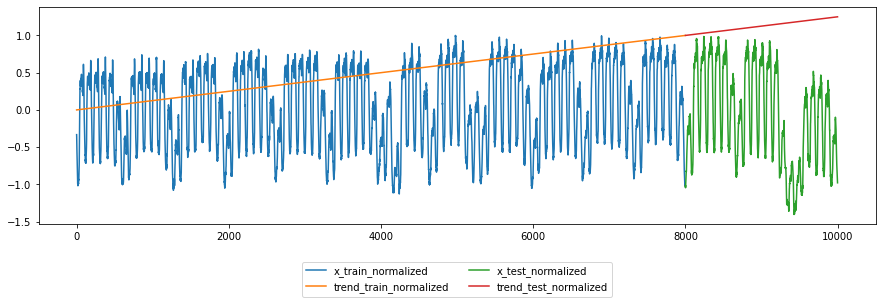

In [67]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='trend_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='trend_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

5. Truncate

In [68]:
def truncate(x, feature_cols=range(2), target_cols=range(2), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(2), target_cols=range(2), 
                            label_col=2, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(9781, 200, 2) (9781, 20, 2) (9781,)


In [69]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(7800, 200, 2) (7800, 20, 2)
(1981, 200, 2) (1981, 20, 2)


In [70]:
data = {
    'X_input_train': X_input_train, 
    'X_output_train': X_output_train, 
    'X_input_test': X_input_test, 
    'X_output_test': X_output_test,
    'X_trend': y_trend,
    'x_trend_param': x_trend_param,
    'x_train_max': x_train_max
         }


pkl.dump(data, open('../Data/data.pkl', 'wb'))